# The Simpsons Characters identification

### Group 17

- Chen, Kun - 8977010
- Ku, Shih-Chieh - 8906826

 ![The Simpsons](./Simpsons_cast.png)

### Objective
<hr>The objective of this project is to develop a deep learning model capable of accurately classify the different characters from the popular animated television series "The Simpsons" based on images. <br><br>

### Motivation
<hr>

[The Simpsons](https://www.wikiwand.com/en/The_Simpsons) is one of the longest-running and most beloved animated series, featuring a vast and diverse array of characters. Predicting these characters from images is not only a fun and engaging task but also holds practical applications in media analysis, entertainment, and fan engagement. <br><br>
Moreover, The Simpsons' style tends to use flat colors and simplistic character compositions, unlike realistic images which incorporate shadows, angles, profiles, and shapes. Given these differences, we are interested in determining whether training a model on The Simpsons' data would be more challenging or if achieving good performance would be relatively easier. <br><br>


The number of data set ([Data set link (Kaggle)](https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset/data)):
- 20933 (images)
- 28601 (images), after data augmentation
- 42 classes
<br>

Referenced code:
- [Simpsons Image Classification -CNN | Val_acc=93%](https://www.kaggle.com/code/everydaycodings/simpsons-image-classification-cnn-val-acc-93)
- [Recognize the Simpsons TensorFlow (88% acc.)](https://www.kaggle.com/code/databeru/recognize-the-simpsons-tensorflow-88-acc)
- [CNN + ResNet](https://www.kaggle.com/code/vellyy/cnn-resnet)
<br>

References:
- [Keras Applications](https://keras.io/api/applications/)
<br>

The pre-trained models used:
- [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)
- [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)

In [1]:
import os
import tensorflow as tf
import keras
import matplotlib.image as mpimg
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

### Split the data into train, test and validation sets

In [2]:
import splitfolders

input_dir = "./input/the-simpsons-characters-dataset/"
output_dir = "./data"

splitfolders.ratio(input_dir, output=output_dir, seed=66, ratio=(0.8, 0.1, 0.1))

Copying files: 0 files [00:00, ? files/s]

Copying files: 20933 files [00:26, 778.39 files/s]


In [5]:

train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

image_size = (180, 180, 3)

epochs = 50 

batch_size = 100

labels = os.listdir(train_dir)

### **ImageDataGenerator** & Load data

The ImageDataGenerator function would randomly augment the image without memory overload, it known as on-the-fly data augmentation.
It would augment TotalNumberOfTrainingData/BatchSize, which is 16727 /100 => 167 images for each epoch, to expand the variety of training samples without increasing storage demands

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [6]:
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)

val_set = test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False
)

Found 16727 images belonging to 42 classes.
Found 2073 images belonging to 42 classes.
Found 2133 images belonging to 42 classes.


### Gallery of data - the main role of The Simpsons series, who is Homer Simpson

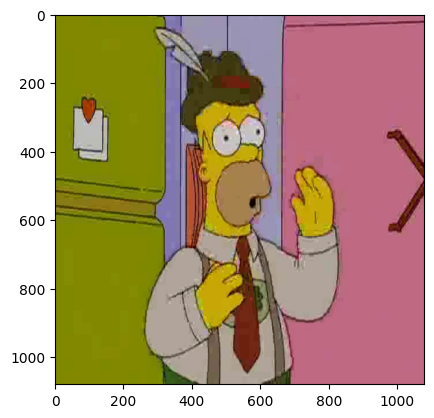

In [7]:
img_path = "./data/train/homer_simpson/pic_0028.jpg"
img = image.load_img(img_path, target_size=(1080, 1080, 3))
plt.imshow(img)
plt.show()

### Display each classes with one image

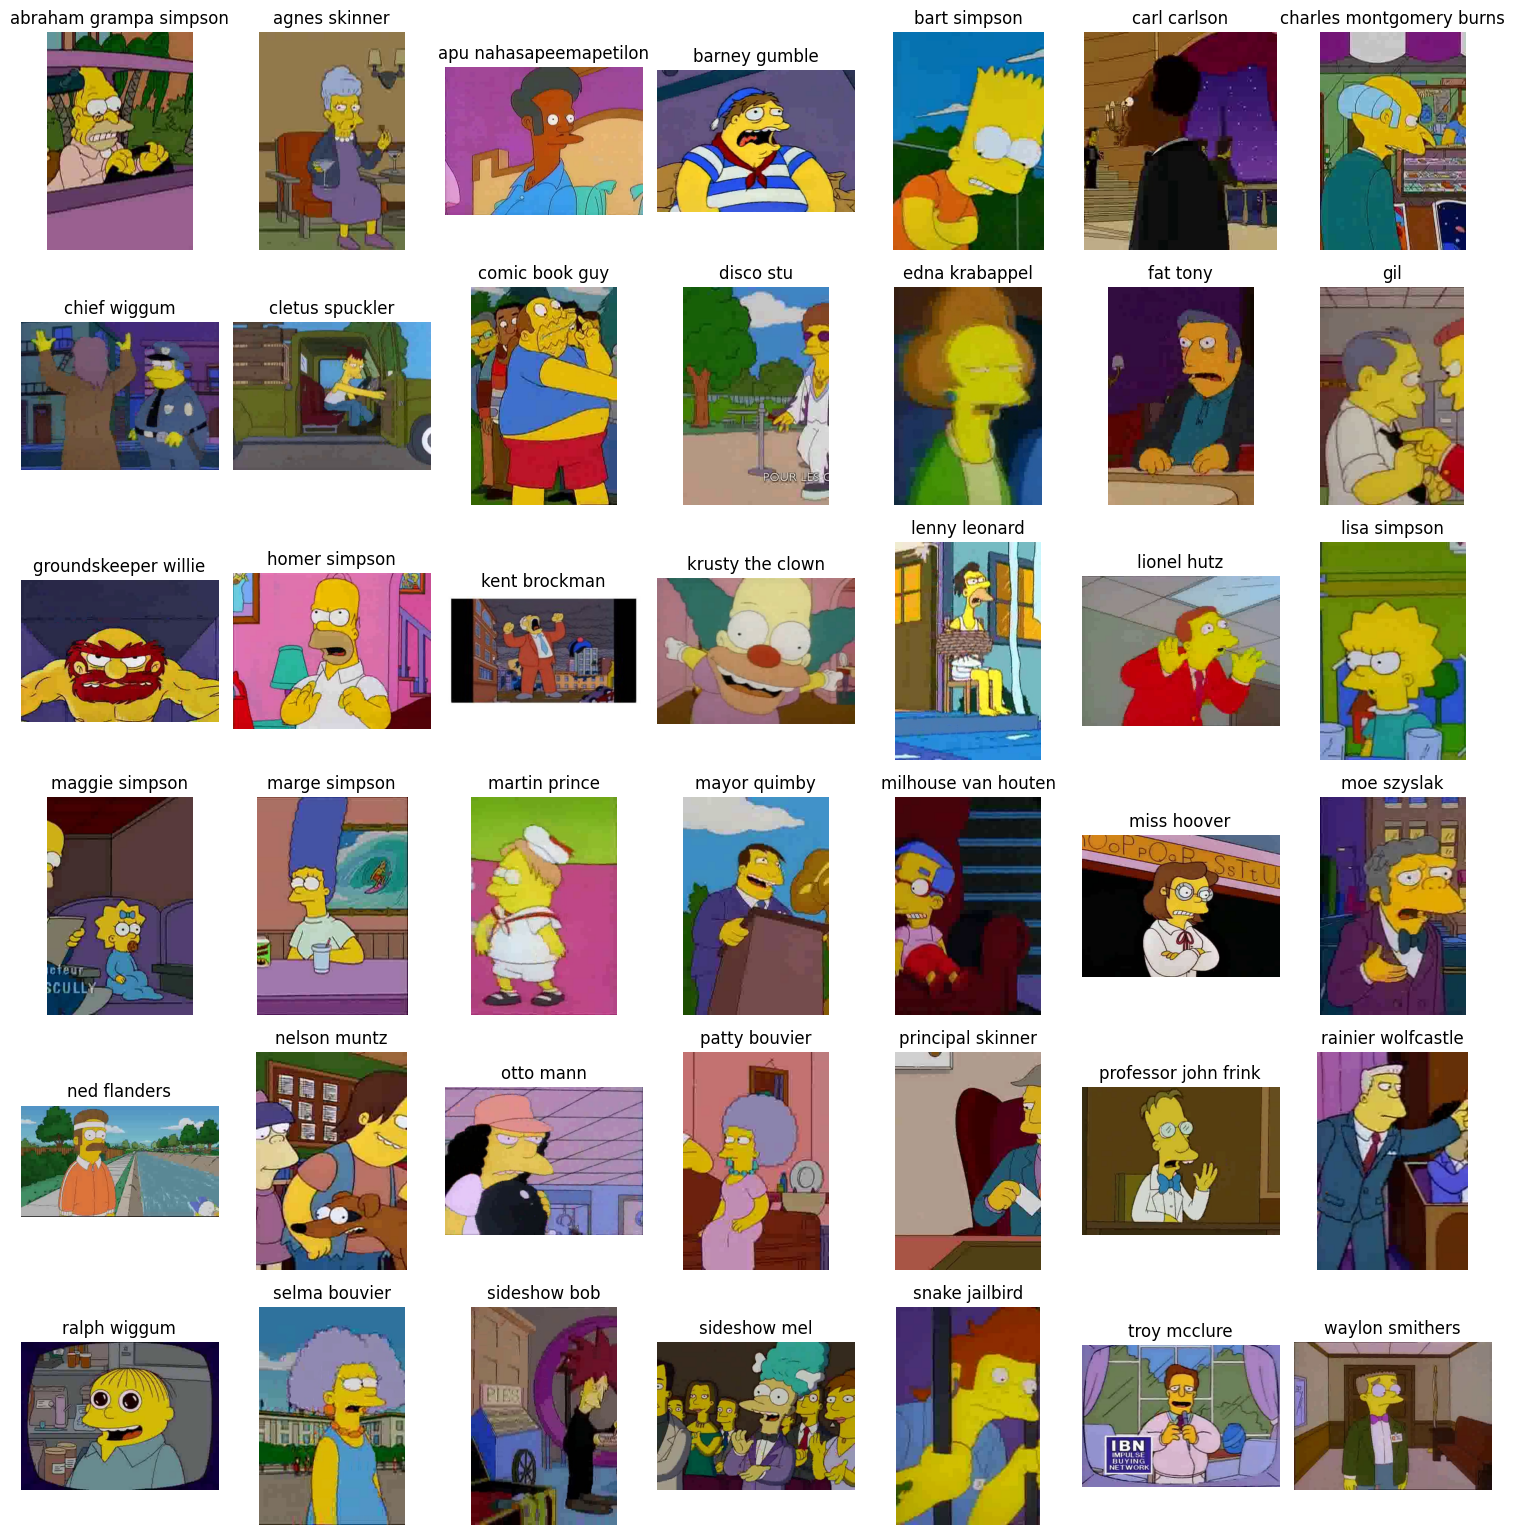

In [9]:
classes = list(training_set.class_indices.keys())
train_dir = './data/train'

def plot_image(size):
    plt.figure(figsize=(15, 18))
    for i, class_1 in enumerate(classes):

        folder_path = f"{train_dir}/{class_1}"
        files = os.listdir(folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
        random_file = random.choice(files)

        plt.subplot(size, size, i + 1)
        img = mpimg.imread(f"{folder_path}/{random_file}")
        plt.imshow(img)
        plt.axis("off")
        plt.title(' '.join(class_1.split("_")))
    plt.tight_layout()
    plt.show()


plot_image(7)

### Showing total number of each class (Imbalanced dataset)

In [7]:
def plot_size(len_l):
    plt.figure(figsize=(15, 15))
    ax = sns.barplot(x=len_l, y=classes, orient="h", color="navy")
    ax.set_xticks(np.arange(0, 2000, 2000))
    ax.set_xlabel("Number of Images")
    ax.set_ylabel("Classes")
    ax.set_title("Number of samples for each class", fontsize=20)
    for i, p in enumerate(ax.patches):
        ax.text(
            p.get_width(),
            p.get_y() + p.get_height() / 2.0,
            "{}".format(len_l[i]),
            va="center",
            fontsize=15,
        )

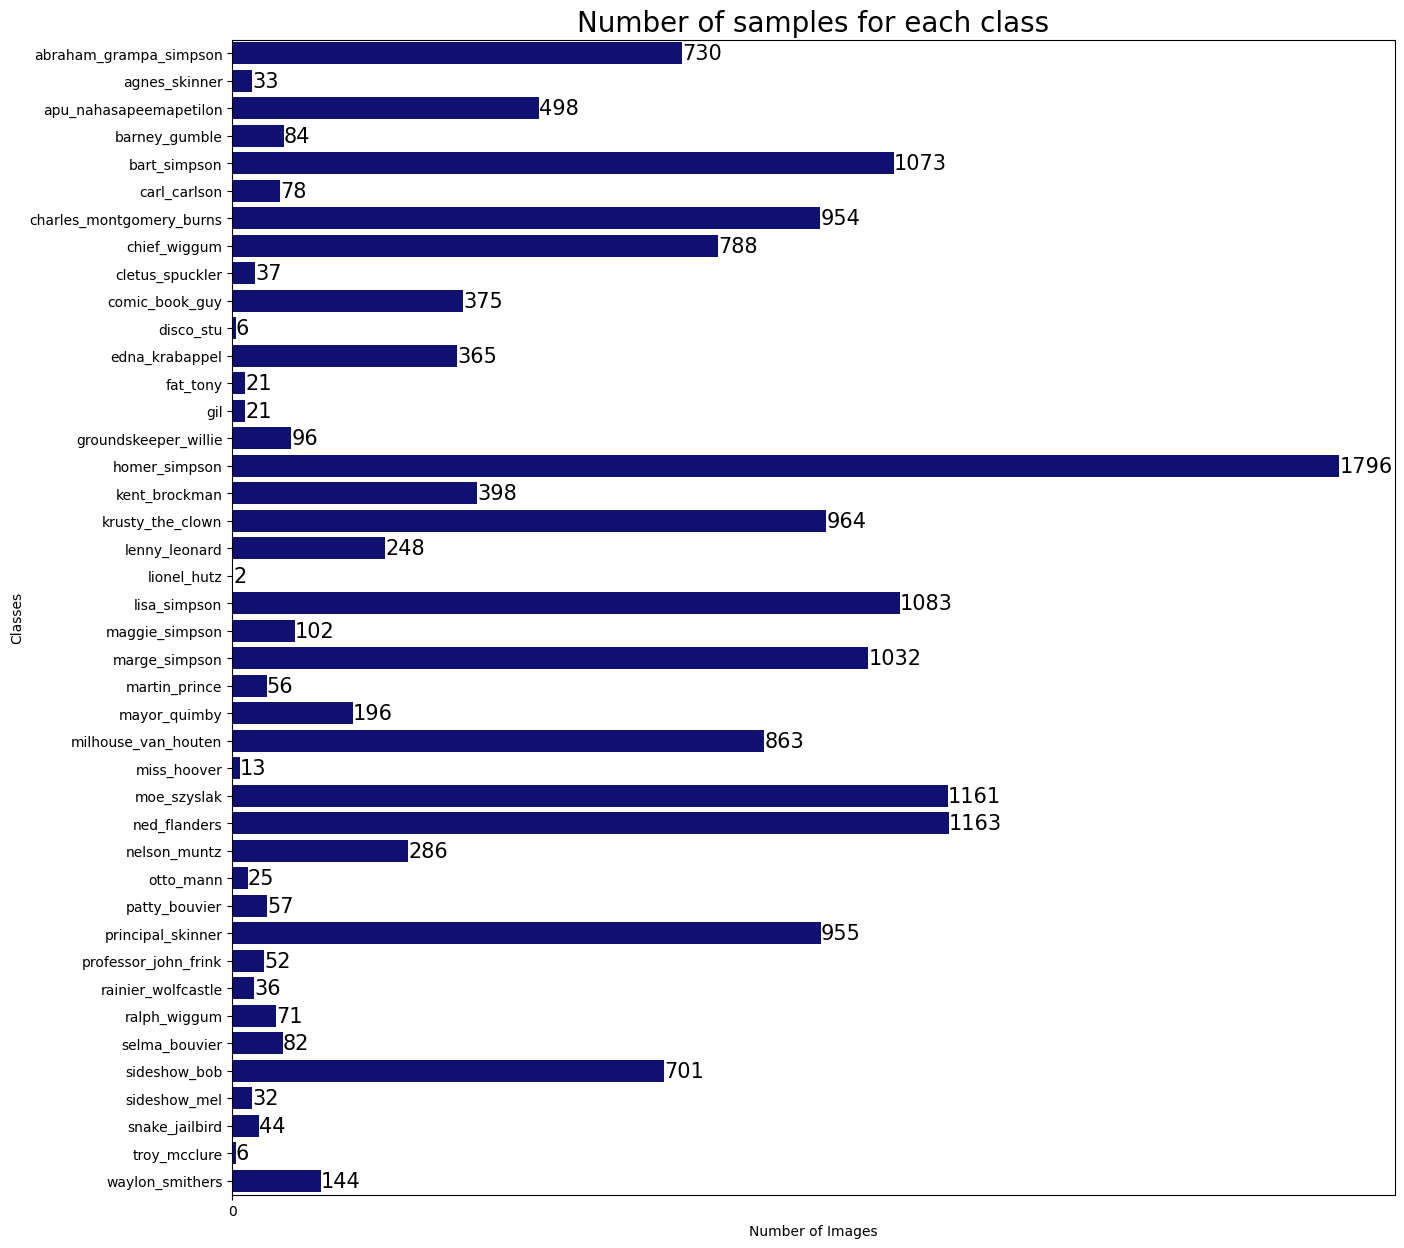

In [10]:
len_list = []

for i, class_ in enumerate(classes):
    len_list.append(len(os.listdir(f"{train_dir}/{class_}")))
        
plot_size(len_list)

### Data Augmentation, for the class which has lower 100 images add 9 times the number of origin images

In [11]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    # image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image

for i, class_ in enumerate(classes):
    if len_list[i] < 100:
        folder_path = f"{train_dir}/{class_}"
        files = os.listdir(folder_path)
        seq = len_list[i]
        for file_ in files:
            for i in range(9):
                img = mpimg.imread(f"{folder_path}/{file_}")
                
                image = tf.io.read_file(f"{folder_path}/{file_}")
                image = tf.image.decode_jpeg(image, channels=3)
                augmented_image = augment_image(image)
                img = Image.fromarray(augmented_image.numpy())
                padded_number = str(seq).zfill(4)
                img.save(os.path.join(folder_path, f"pic_{padded_number}.png"))
                seq += 1

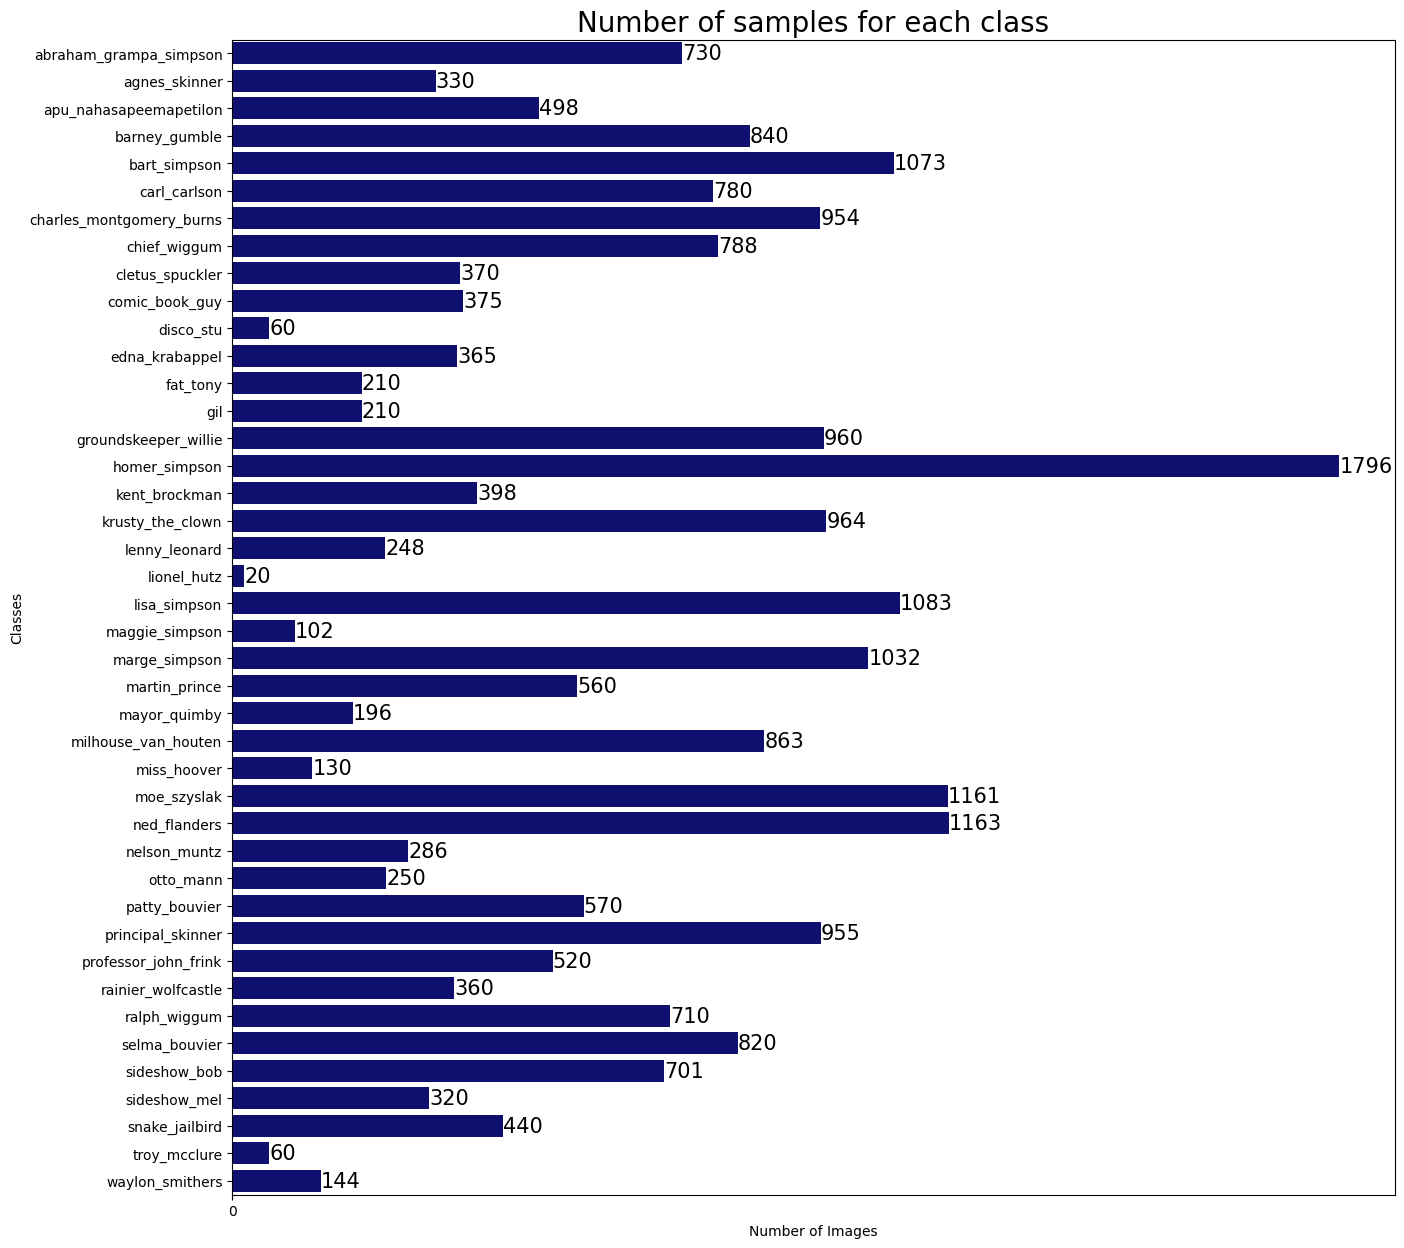

In [12]:
len_list_ = []

for i, class_ in enumerate(classes):
    len_list_.append(len(os.listdir(f"{train_dir}/{class_}")))
        
plot_size(len_list_)

In [13]:
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)

Found 24395 images belonging to 42 classes.


### Customeized CNN model



The following is referenced from [Simpsons Image Classification -CNN | Val_acc=93%](https://www.kaggle.com/code/everydaycodings/simpsons-image-classification-cnn-val-acc-93)

In [14]:
model_cus = Sequential()
model_cus.add(Conv2D(32, (3, 3), padding="same", input_shape=image_size, activation="relu"))
model_cus.add(Conv2D(32, (3, 3), activation="relu"))
model_cus.add(MaxPooling2D(pool_size=(2, 2)))
model_cus.add(Dropout(0.2))

model_cus.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model_cus.add(Conv2D(64, (3, 3), activation="relu"))
model_cus.add(MaxPooling2D(pool_size=(2, 2)))
model_cus.add(Dropout(0.2))

model_cus.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model_cus.add(Conv2D(256, (3, 3), activation="relu"))
model_cus.add(MaxPooling2D(pool_size=(2, 2)))
model_cus.add(Dropout(0.2))

model_cus.add(Flatten())
model_cus.add(Dense(1024, activation="relu"))
model_cus.add(Dropout(0.5))
model_cus.add(Dense(len(labels), activation="softmax"))

### Using same hyperparameters for three models

Except for the model itself, all other parameters are the same, like:
- Loss: Categorical Crossentropy
- Optimizer: Adam
- Last Layer: 1024 with relu
- Output Activation: softmax

In [15]:
model_cus.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
model_cus.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 64)        36928     
                                                        

In [17]:
checkpoint_filepath_cus = "./models/cus.h5"

model_cus_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_cus,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

callbacks = [
    EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
    model_cus_checkpoint_callback,
]

In [18]:
history_customized = model_cus.fit(
    training_set, epochs=epochs, validation_data=val_set, callbacks=callbacks
)

Epoch 1/50
244/244 [==============================] - 253s 967ms/step - loss: 3.5161 - accuracy: 0.0810 - val_loss: 2.9515 - val_accuracy: 0.2262
Epoch 2/50
244/244 [==============================] - 111s 451ms/step - loss: 3.0078 - accuracy: 0.1891 - val_loss: 2.3095 - val_accuracy: 0.3739
Epoch 3/50
244/244 [==============================] - 111s 451ms/step - loss: 2.5875 - accuracy: 0.2971 - val_loss: 1.8757 - val_accuracy: 0.5089
Epoch 4/50
244/244 [==============================] - 110s 449ms/step - loss: 2.2122 - accuracy: 0.3975 - val_loss: 1.4827 - val_accuracy: 0.5909
Epoch 5/50
244/244 [==============================] - 110s 450ms/step - loss: 1.8888 - accuracy: 0.4776 - val_loss: 1.2111 - val_accuracy: 0.6585
Epoch 6/50
244/244 [==============================] - 110s 449ms/step - loss: 1.6264 - accuracy: 0.5424 - val_loss: 0.9674 - val_accuracy: 0.7236
Epoch 7/50
244/244 [==============================] - 110s 451ms/step - loss: 1.4421 - accuracy: 0.5960 - val_loss: 0.9006 -

**Trends for accuracy and loss: training dataset versus validation set**

**Load highest val-accuracy model**

In [19]:
best_from_custome_customized_model = keras.models.load_model(checkpoint_filepath_cus)

Table below is referenced from Keras (https://keras.io/api/applications/)

| **Model** | **Size (MB)** | **Top-1 Accuracy** | **Top-5 Accuracy** | **Parameters** | **Depth** | **Time (ms) per inference step (CPU)** | **Time (ms) per inference step (GPU)** |
| --- | --- | --- | --- | --- | --- | --- | --- |
| [Xception](https://keras.io/api/applications/xception) | 88  | 79.0% | 94.5% | 22.9M | 81  | 109.4 | 8.1 |
| [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) | 528 | 71.3% | 90.1% | 138.4M | 16  | 69.5 | 4.2 |
| [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) | 549 | 71.3% | 90.0% | 143.7M | 19  | 84.8 | 4.4 |
| [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function) | 98  | 74.9% | 92.1% | 25.6M | 107 | 58.2 | 4.6 |
| [ResNet50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) | 98  | 76.0% | 93.0% | 25.6M | 103 | 45.6 | 4.4 |
| [ResNet101](https://keras.io/api/applications/resnet/#resnet101-function) | 171 | 76.4% | 92.8% | 44.7M | 209 | 89.6 | 5.2 |
| [ResNet101V2](https://keras.io/api/applications/resnet/#resnet101v2-function) | 171 | 77.2% | 93.8% | 44.7M | 205 | 72.7 | 5.4 |
| [ResNet152](https://keras.io/api/applications/resnet/#resnet152-function) | 232 | 76.6% | 93.1% | 60.4M | 311 | 127.4 | 6.5 |
| [ResNet152V2](https://keras.io/api/applications/resnet/#resnet152v2-function) | 232 | 78.0% | 94.2% | 60.4M | 307 | 107.5 | 6.6 |
| [InceptionV3](https://keras.io/api/applications/inceptionv3) | 92  | 77.9% | 93.7% | 23.9M | 189 | 42.2 | 6.9 |
| [InceptionResNetV2](https://keras.io/api/applications/inceptionresnetv2) | 215 | 80.3% | 95.3% | 55.9M | 449 | 130.2 | 10.0 |
| [MobileNet](https://keras.io/api/applications/mobilenet) | 16  | 70.4% | 89.5% | 4.3M | 55  | 22.6 | 3.4 |
| [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) | 14  | 71.3% | 90.1% | 3.5M | 105 | 25.9 | 3.8 |
| [DenseNet121](https://keras.io/api/applications/densenet/#densenet121-function) | 33  | 75.0% | 92.3% | 8.1M | 242 | 77.1 | 5.4 |
| [DenseNet169](https://keras.io/api/applications/densenet/#densenet169-function) | 57  | 76.2% | 93.2% | 14.3M | 338 | 96.4 | 6.3 |
| [DenseNet201](https://keras.io/api/applications/densenet/#densenet201-function) | 80  | 77.3% | 93.6% | 20.2M | 402 | 127.2 | 6.7 |
| [NASNetMobile](https://keras.io/api/applications/nasnet/#nasnetmobile-function) | 23  | 74.4% | 91.9% | 5.3M | 389 | 27.0 | 6.7 |
| [NASNetLarge](https://keras.io/api/applications/nasnet/#nasnetlarge-function) | 343 | 82.5% | 96.0% | 88.9M | 533 | 344.5 | 20.0 |
| [EfficientNetB0](https://keras.io/api/applications/efficientnet/#efficientnetb0-function) | 29  | 77.1% | 93.3% | 5.3M | 132 | 46.0 | 4.9 |
| [EfficientNetB1](https://keras.io/api/applications/efficientnet/#efficientnetb1-function) | 31  | 79.1% | 94.4% | 7.9M | 186 | 60.2 | 5.6 |
| [EfficientNetB2](https://keras.io/api/applications/efficientnet/#efficientnetb2-function) | 36  | 80.1% | 94.9% | 9.2M | 186 | 80.8 | 6.5 |
| [EfficientNetB3](https://keras.io/api/applications/efficientnet/#efficientnetb3-function) | 48  | 81.6% | 95.7% | 12.3M | 210 | 140.0 | 8.8 |
| [EfficientNetB4](https://keras.io/api/applications/efficientnet/#efficientnetb4-function) | 75  | 82.9% | 96.4% | 19.5M | 258 | 308.3 | 15.1 |
| [EfficientNetB5](https://keras.io/api/applications/efficientnet/#efficientnetb5-function) | 118 | 83.6% | 96.7% | 30.6M | 312 | 579.2 | 25.3 |
| [EfficientNetB6](https://keras.io/api/applications/efficientnet/#efficientnetb6-function) | 166 | 84.0% | 96.8% | 43.3M | 360 | 958.1 | 40.4 |
| [EfficientNetB7](https://keras.io/api/applications/efficientnet/#efficientnetb7-function) | 256 | 84.3% | 97.0% | 66.7M | 438 | 1578.9 | 61.6 |
| [EfficientNetV2B0](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b0-function) | 29  | 78.7% | 94.3% | 7.2M | \-  | \-  | \-  |
| [EfficientNetV2B1](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b1-function) | 34  | 79.8% | 95.0% | 8.2M | \-  | \-  | \-  |
| [EfficientNetV2B2](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b2-function) | 42  | 80.5% | 95.1% | 10.2M | \-  | \-  | \-  |
| [EfficientNetV2B3](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b3-function) | 59  | 82.0% | 95.8% | 14.5M | \-  | \-  | \-  |
| [EfficientNetV2S](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2s-function) | 88  | 83.9% | 96.7% | 21.6M | \-  | \-  | \-  |
| [EfficientNetV2M](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2m-function) | 220 | 85.3% | 97.4% | 54.4M | \-  | \-  | \-  |
| [EfficientNetV2L](https://keras.io/api/applications/efficientnet_v2/#efficientnetv2l-function) | 479 | 85.7% | 97.5% | 119.0M | \-  | \-  | \-  |
| [ConvNeXtTiny](https://keras.io/api/applications/convnext/#convnexttiny-function) | 109.42 | 81.3% | \-  | 28.6M | \-  | \-  | \-  |
| [ConvNeXtSmall](https://keras.io/api/applications/convnext/#convnextsmall-function) | 192.29 | 82.3% | \-  | 50.2M | \-  | \-  | \-  |
| [ConvNeXtBase](https://keras.io/api/applications/convnext/#convnextbase-function) | 338.58 | 85.3% | \-  | 88.5M | \-  | \-  | \-  |
| [ConvNeXtLarge](https://keras.io/api/applications/convnext/#convnextlarge-function) | 755.07 | 86.3% | \-  | 197.7M | \-  | \-  | \-  |
| [ConvNeXtXLarge](https://keras.io/api/applications/convnext/#convnextxlarge-function) | 1310 | 86.7% | \-  | 350.1M | \-  | \-  | \-  |

### MobileNetV2 model

The following is referenced from [Recognize the Simpsons TensorFlow (88% acc.)](https://www.kaggle.com/code/databeru/recognize-the-simpsons-tensorflow-88-acc)

In [20]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [21]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation="relu")(pretrained_model.output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(Dropout(0.5))(x)

outputs = tf.keras.layers.Dense(42, activation="softmax")(x)
model_MNV2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_MNV2.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [22]:
model_MNV2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [23]:
model_MNV2.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

checkpoint_filepath_MNV2 = "./models/MNV2.h5"

model_MNV2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_MNV2,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

callbacks_MNV2 = [
    model_MNV2_checkpoint_callback,
    EarlyStopping(monitor="val_accuracy", patience=5, mode="max"),
]

history_MNV2 = model_MNV2.fit(
    training_set, validation_data=val_set, epochs=epochs, callbacks=callbacks_MNV2
)

Epoch 1/50
244/244 [==============================] - 108s 434ms/step - loss: 2.4468 - accuracy: 0.3495 - val_loss: 1.8542 - val_accuracy: 0.4954
Epoch 2/50
244/244 [==============================] - 106s 435ms/step - loss: 1.7848 - accuracy: 0.5089 - val_loss: 1.7979 - val_accuracy: 0.5104
Epoch 3/50
244/244 [==============================] - 106s 434ms/step - loss: 1.5545 - accuracy: 0.5696 - val_loss: 1.5409 - val_accuracy: 0.5712
Epoch 4/50
244/244 [==============================] - 106s 433ms/step - loss: 1.4255 - accuracy: 0.5974 - val_loss: 1.5524 - val_accuracy: 0.5678
Epoch 5/50
244/244 [==============================] - 105s 429ms/step - loss: 1.3348 - accuracy: 0.6188 - val_loss: 1.4764 - val_accuracy: 0.5861
Epoch 6/50
244/244 [==============================] - 106s 433ms/step - loss: 1.2664 - accuracy: 0.6415 - val_loss: 1.4505 - val_accuracy: 0.5953
Epoch 7/50
244/244 [==============================] - 106s 433ms/step - loss: 1.2224 - accuracy: 0.6489 - val_loss: 1.4238 -

**Load highest val-accuracy model - Mobile Net V2**

In [24]:
best_from_custome_MNV2_model = keras.models.load_model(checkpoint_filepath_MNV2)

### ResNet50

The following is referenced from [CNN + ResNet](https://www.kaggle.com/code/vellyy/cnn-resnet)

In [25]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [26]:
model_RN50=Sequential()
model_RN50.add(ResNet50(include_top=False,
               pooling='max'))
model_RN50.add(Flatten())
model_RN50.add(Dense(1024, activation="relu"))
model_RN50.add(Dropout(0.5))
model_RN50.add(Dense(len(labels), activation='softmax'))

In [27]:
model_RN50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 42)                43050     
                                                                 
Total params: 25,728,938
Trainable params: 25,675,818
Non-trainable params: 53,120
_________________________________________________________________


In [28]:
model_RN50.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
checkpoint_filepath_RN50 = "./models/RN50.h5"

model_RN50_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_RN50,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

callbacks_MNV2 = [
    model_RN50_checkpoint_callback,
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
]

### For some reason, I need to decrease the number of batche size to avoid the error for GPU out of memory

In [30]:
training_set_RN50 = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size[:2],
    batch_size=35,
    class_mode="categorical",
    color_mode="rgb",
)

val_set_RN50 = test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size[:2],
    batch_size=35,
    class_mode="categorical",
    color_mode="rgb",
)

Found 24395 images belonging to 42 classes.
Found 2073 images belonging to 42 classes.


In [31]:
history_RN50 = model_RN50.fit(
    training_set_RN50, epochs=epochs, validation_data=val_set_RN50, callbacks=callbacks_MNV2
)

Epoch 1/50
697/697 [==============================] - 125s 173ms/step - loss: 3.2562 - accuracy: 0.2537 - val_loss: 4.0804 - val_accuracy: 0.0145
Epoch 2/50
697/697 [==============================] - 120s 172ms/step - loss: 1.6030 - accuracy: 0.5683 - val_loss: 1.8252 - val_accuracy: 0.5297
Epoch 3/50
697/697 [==============================] - 120s 173ms/step - loss: 1.3147 - accuracy: 0.6454 - val_loss: 0.8303 - val_accuracy: 0.7771
Epoch 4/50
697/697 [==============================] - 120s 172ms/step - loss: 1.1980 - accuracy: 0.6780 - val_loss: 5.2982 - val_accuracy: 0.0550
Epoch 5/50
697/697 [==============================] - 120s 172ms/step - loss: 1.0553 - accuracy: 0.7139 - val_loss: 2.3258 - val_accuracy: 0.4568
Epoch 6/50
697/697 [==============================] - 120s 172ms/step - loss: 0.8492 - accuracy: 0.7779 - val_loss: 1.0132 - val_accuracy: 0.7192
Epoch 7/50
697/697 [==============================] - 120s 172ms/step - loss: 1.1842 - accuracy: 0.6836 - val_loss: 1.1694 -

**Load highest val-accuracy model - Res Net 50**

In [32]:
best_from_custome_RN50_model = keras.models.load_model(checkpoint_filepath_RN50)

### Evaluation

In [33]:
acc_customized = history_customized.history["accuracy"]
val_acc_customized = history_customized.history["val_accuracy"]
loss_customized = history_customized.history["loss"]
val_loss_customized = history_customized.history["val_loss"]
epochs_customized = range(1, len(acc_customized) + 1)

acc_MNV2 = history_MNV2.history["accuracy"]
val_acc_MNV2 = history_MNV2.history["val_accuracy"]
loss_MNV2 = history_MNV2.history["loss"]
val_loss_MNV2 = history_MNV2.history["val_loss"]
epochs_MNV2 = range(1, len(acc_MNV2) + 1)

acc_RN50 = history_RN50.history["accuracy"]
val_acc_RN50 = history_RN50.history["val_accuracy"]
loss_RN50 = history_RN50.history["loss"]
val_loss_RN50 = history_RN50.history["val_loss"]
epochs_RN50 = range(1, len(acc_RN50) + 1)

### Accuracy Comparison between these thee models

According to the following graphics, each presents slightly different situations. For the customized model, the validation loss and validation accuracy are consistently better than the results of the training dataset. Several factors may contribute to this. One possibility is that the model is too complex for the training data, leading to underfitting or overfitting. Additionally, the validation dataset may contain more generalized data, allowing the model to perform better on validation.

For the middle image, the Mobile Net V2 model presented the opposite results, where the performances on the validation data consistently showed lower quality compared to the performance on the training data. The reason is clear: the model tends to overfit the training data and consequently does not perform well on validation or other data.

Lastly, the trend on the chart exhibits significant volatility with the ResNet50 model. Despite providing excellent performance (at some epochs), it indicates that this model is inherently unstable and unreliable. Additionally, we observe that the validation loss and validation accuracy are higher (at some epochs) than those of the training data. I believe this trend may be caused by the model's complexity being unsuitable for this dataset, and perhaps the model is overly sensitive to certain data, leading to fluctuations between good and bad performance.

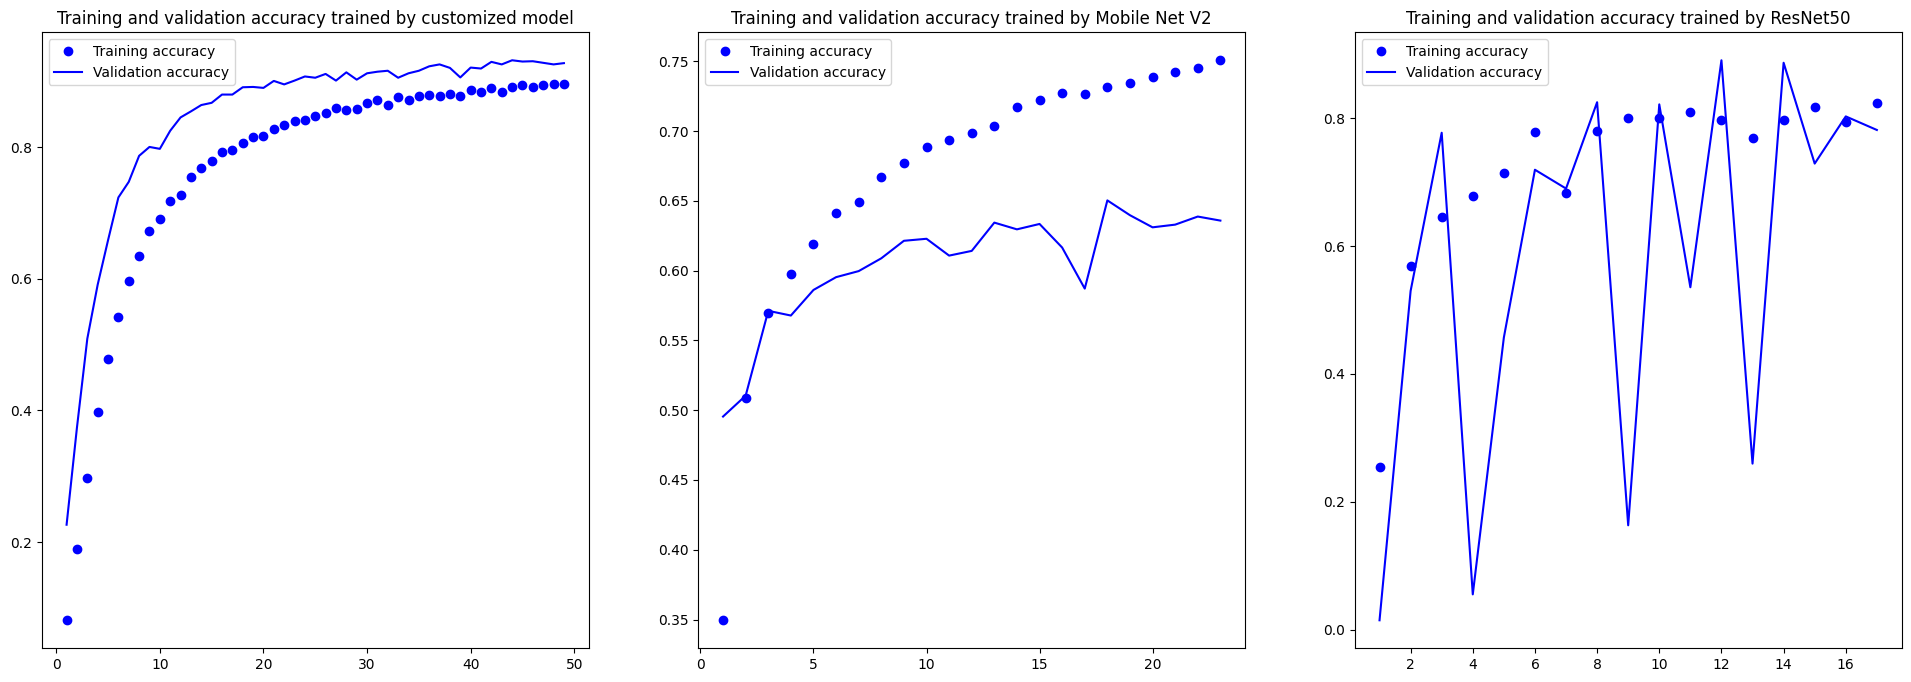

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[0].plot(epochs_customized, acc_customized, "bo", label="Training accuracy")
axs[0].plot(epochs_customized, val_acc_customized, "b", label="Validation accuracy")
axs[0].set_title("Training and validation accuracy trained by customized model")
axs[0].legend()


axs[1].plot(epochs_MNV2, acc_MNV2, "bo", label="Training accuracy")
axs[1].plot(epochs_MNV2, val_acc_MNV2, "b", label="Validation accuracy")
axs[1].set_title("Training and validation accuracy trained by Mobile Net V2")
axs[1].legend()


axs[2].plot(epochs_RN50, acc_RN50, "bo", label="Training accuracy")
axs[2].plot(epochs_RN50, val_acc_RN50, "b", label="Validation accuracy")
axs[2].set_title("Training and validation accuracy trained by ResNet50")
axs[2].legend()


Loss Comparison between these thee models

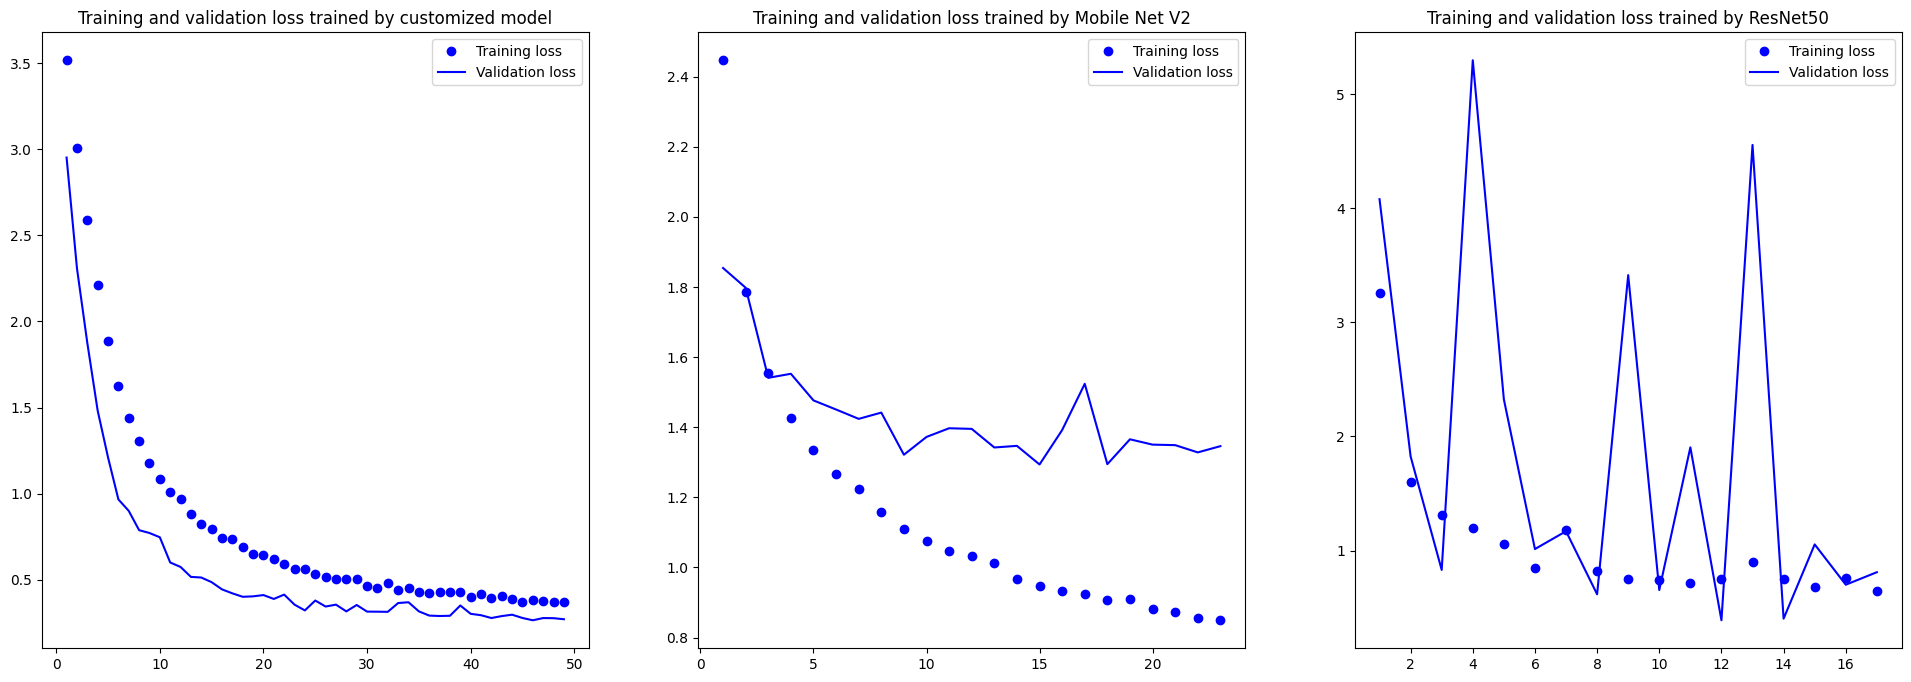

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[0].plot(epochs_customized, loss_customized, "bo", label="Training loss")
axs[0].plot(epochs_customized, val_loss_customized, "b", label="Validation loss")
axs[0].set_title("Training and validation loss trained by customized model")
axs[0].legend()

axs[1].plot(epochs_MNV2, loss_MNV2, "bo", label="Training loss")
axs[1].plot(epochs_MNV2, val_loss_MNV2, "b", label="Validation loss")
axs[1].set_title("Training and validation loss trained by Mobile Net V2")
axs[1].legend()

axs[2].plot(epochs_RN50, loss_RN50, "bo", label="Training loss")
axs[2].plot(epochs_RN50, val_loss_RN50, "b", label="Validation loss")
axs[2].set_title("Training and validation loss trained by ResNet50")
axs[2].legend()

### Predictions

In [18]:
checkpoint_filepath_cus = "./models/cus.h5"
checkpoint_filepath_MNV2 = "./models/MNV2.h5"
checkpoint_filepath_RN50 = "./models/RN50.h5"

best_from_custome_customized_model = keras.models.load_model(checkpoint_filepath_cus)
best_from_custome_MNV2_model = keras.models.load_model(checkpoint_filepath_MNV2)
best_from_custome_RN50_model = keras.models.load_model(checkpoint_filepath_RN50)

In [17]:
y_true = test_set.classes
y_test_true = keras.utils.to_categorical(y_true, num_classes=len(labels))
y_test_true = np.argmax(y_test_true, axis=1)

### Evaluation of **customized model** on test set

In [23]:
y_pred_customized = best_from_custome_customized_model.predict(test_set)
y_pred_customized = np.argmax(y_pred_customized, axis=1)

22/22 [==============================] - 10s 227ms/step


In [15]:
def find_unequal_indexes(list1, list2):
    unequal_indices = []
    min_length = min(len(list1), len(list2))
    
    for i in range(min_length):
        if list1[i] != list2[i]:
            unequal_indices.append(i+1)
            
    for i in range(min_length, max(len(list1), len(list2))):
        unequal_indices.append(i+1)
    
    return unequal_indices


Total number of mis-classification by customized model

In [24]:
unequal_indices_customized = find_unequal_indexes(y_test_true, y_pred_customized)

print(
    f"Total number of mis-classification by customized model: {len(unequal_indices_customized)}, which is {round(len(unequal_indices_customized)/len(y_test_true)*100, 1)}%"
)

Total number of mis-classification by customized model: 168, which is 7.9%


### Classification Report

The accuracy provided by the customized model is 92%, which is really good. For the most class's precision, recall and f1-score are around 80%-90%. However, for some classes, they didn't perform well, the precision from 0.35 to 0.6. I noticed that the class with relatively low support amount, often performed the more bad results.

In [117]:
class_report_customized = classification_report(
    y_test_true, y_pred_customized, zero_division=1, target_names=labels
)
print(class_report_customized)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.88      0.91        92
           agnes_skinner       1.00      0.60      0.75         5
  apu_nahasapeemapetilon       0.90      0.90      0.90        63
           barney_gumble       0.90      0.75      0.82        12
            bart_simpson       0.88      0.91      0.89       135
            carl_carlson       0.58      1.00      0.73        11
charles_montgomery_burns       0.94      0.95      0.95       120
            chief_wiggum       0.93      0.94      0.94       100
         cletus_spuckler       0.80      0.67      0.73         6
          comic_book_guy       0.84      0.88      0.86        48
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.95      0.79      0.86        47
                fat_tony       1.00      1.00      1.00         4
                     gil       0.75      0.75      0.75         4
    groun

### Support amount versus Precision

In [143]:
def plot_support_train_amt(report):
    precision_list = []
    support_list = []
    seq = 0
    for val in report.values():
        if seq != 42:
            precision_list.append(val['precision'])
            support_list.append(val['support'])
            seq+=1

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            
    axs[0].scatter(precision_list, support_list)
    axs[0].set_xlabel('Precision')
    axs[0].set_ylabel('Support amount') 

    axs[1].scatter(precision_list, len_list_)
    axs[1].set_xlabel('Precision')
    axs[1].set_ylabel('Training data set amount') 

According to the below graphics, we can found that there are subtle relationships between precision and support amount (training data amount). When support amount which is the test data of specific classs over than 50, then its precision would around 90% to 100%. Similarly, the amount over than 1000 would reach 90% to 100% precision. So, I think that for the classes' performance, the amount of data is critical.

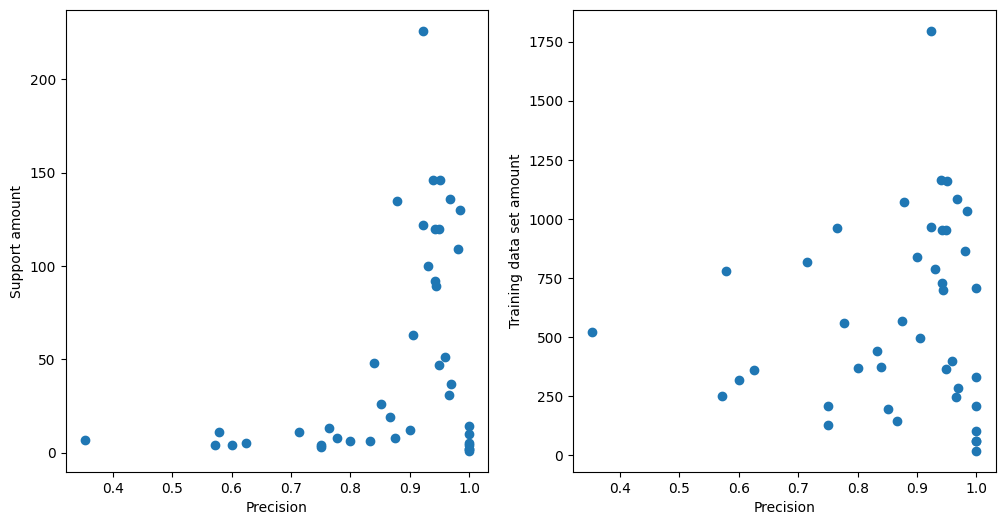

In [144]:
class_report_customized = classification_report(
    y_test_true, y_pred_customized, zero_division=1, output_dict=True
)

plot_support_train_amt(class_report_customized)

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cf):
    plt.figure(figsize=(20, 15))
    sns.heatmap(
        cf,
        annot=False,
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.title("Normalized Confusion Matrix", fontsize=23)
    plt.show()

This is the coufusion matrix which indicates the situation where the ground truth predicted by model to others. The color more bright represents the ground truth are more close to the prediction of the model predicted

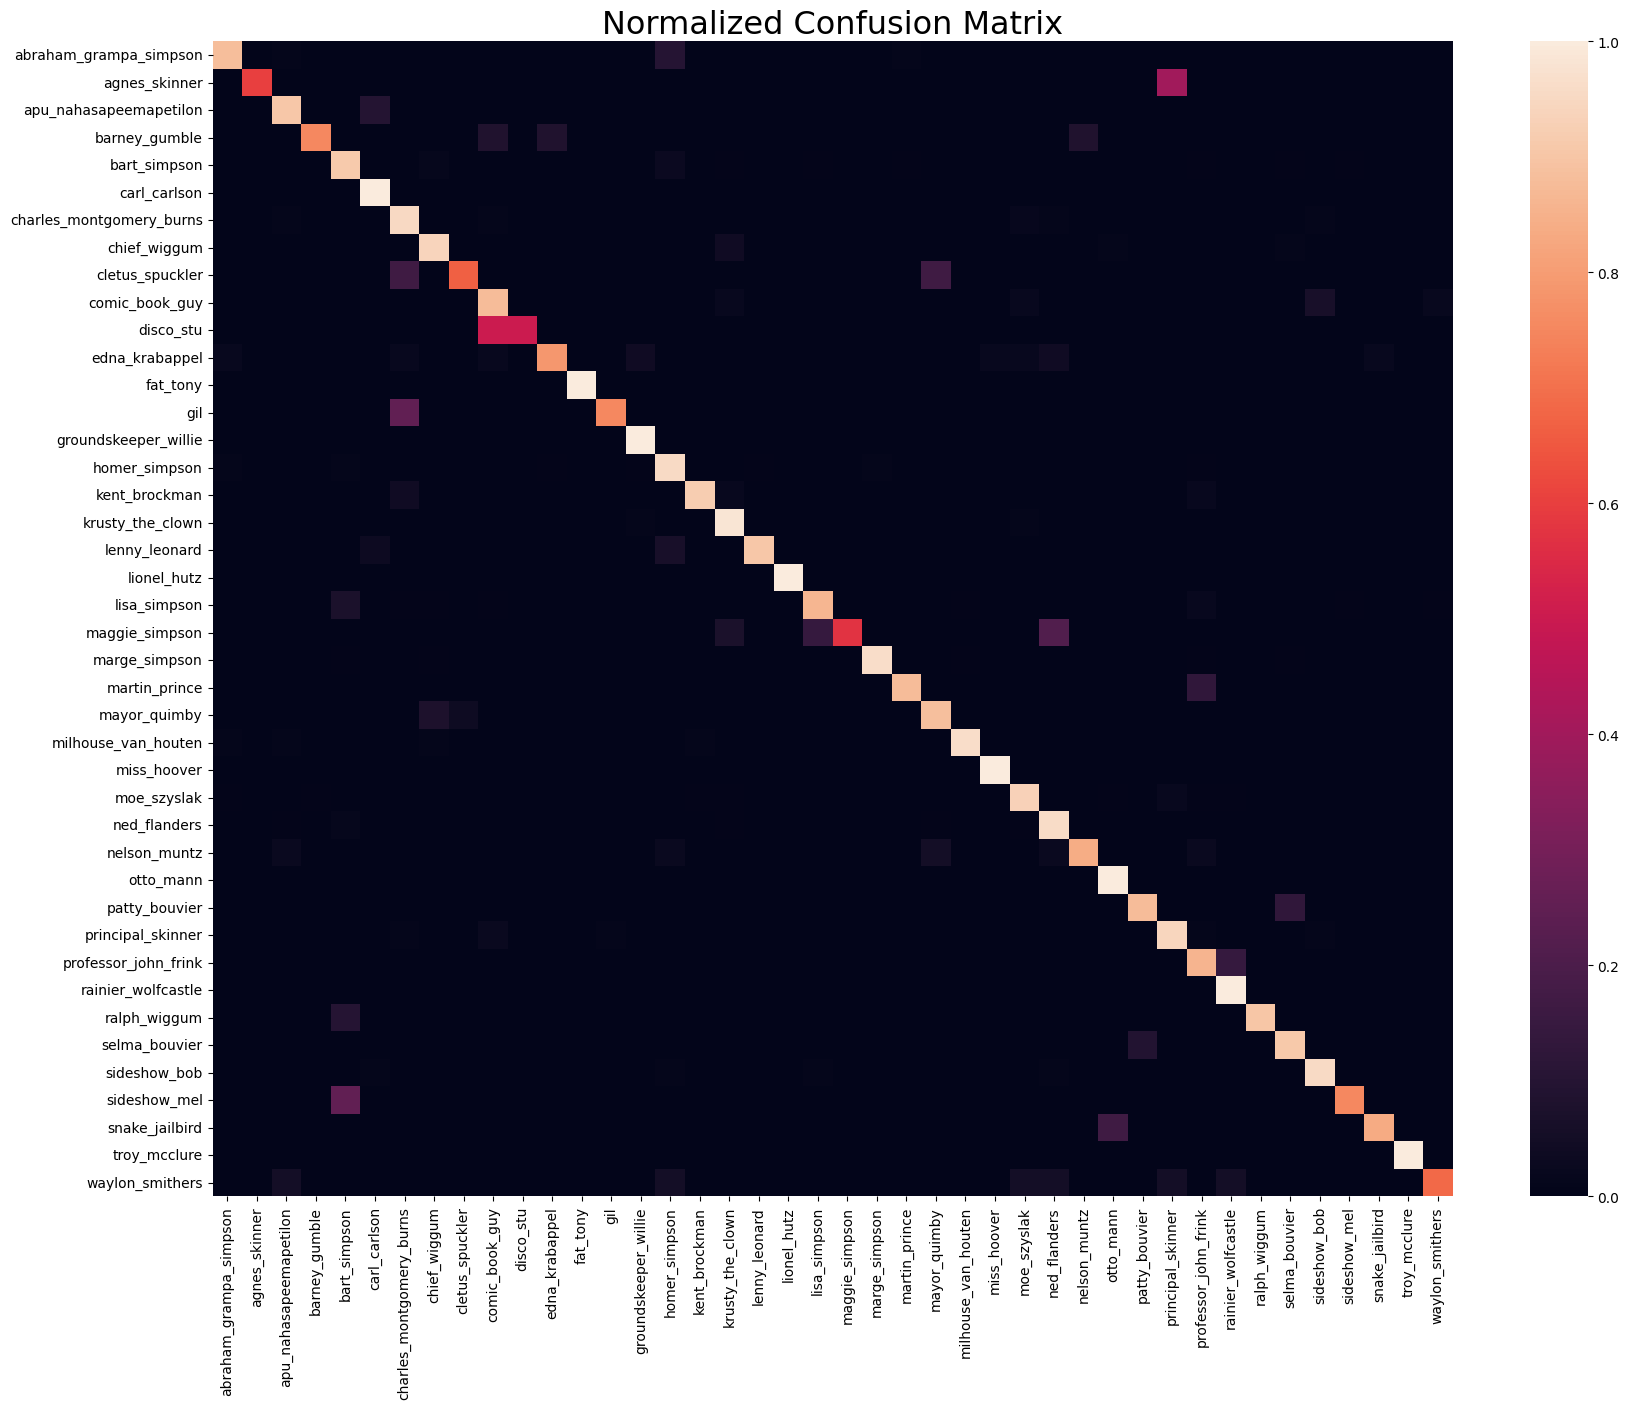

In [148]:
cf_matrix_customized = confusion_matrix(y_test_true, y_pred_customized, normalize="true")
plot_confusion_matrix(cf_matrix_customized)

In [11]:
def plot_specific_images(a, b):
    plt.figure(figsize=(15, 18))
    for i, class_1 in enumerate([a, b]):

        folder_path = f"{train_dir}/{class_1}"
        files = os.listdir(folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
        random_file = random.choice(files)

        plt.subplot(2, 2, i + 1)
        img = mpimg.imread(f"{folder_path}/{random_file}")
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_1)
    plt.tight_layout()
    plt.show()

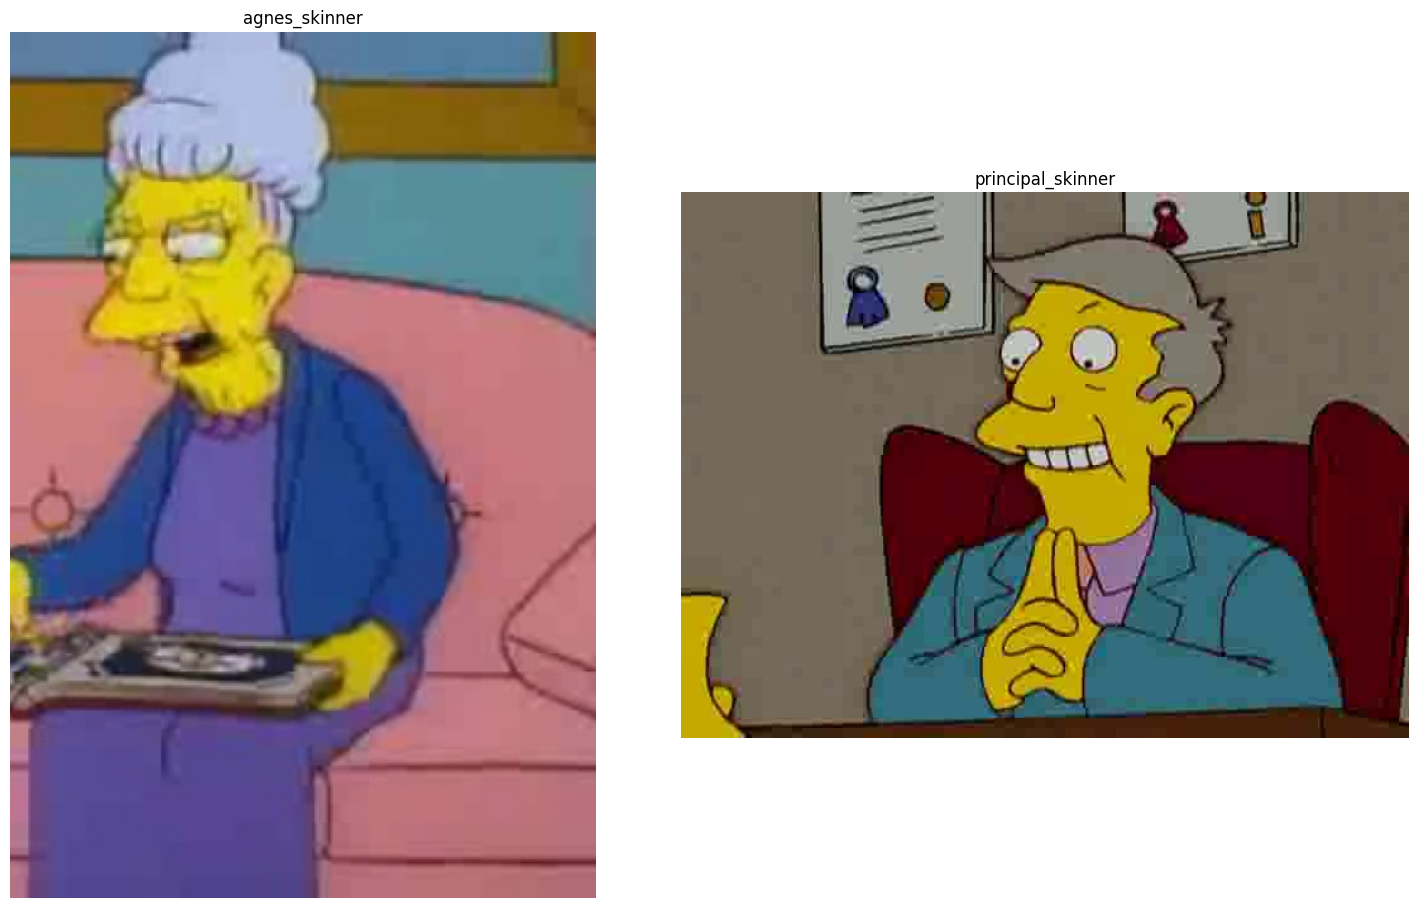

In [15]:
plot_specific_images('agnes_skinner', 'principal_skinner')

Predict on 15 images to see the results

In [16]:
import cv2

def predict_15_imgs(m):
    # Display 15 picture of the dataset with their labels
    fig, axes = plt.subplots(
        nrows=4, ncols=5, figsize=(15, 12), subplot_kw={"xticks": [], "yticks": []}
    )

    for i, ax in enumerate(axes.flat):
        dd = random.randint(1, 41)
        class_name = labels[dd]

        folder_path = f"{train_dir}/{class_name}"
        files = os.listdir(folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
        random_file = random.choice(files)

        file_name = folder_path + "/" + random_file

        img = cv2.imread(file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = cv2.resize(img, (180, 180))
        img = img.astype("float32")

        img_tensor = tf.expand_dims(tf.convert_to_tensor(img), axis=0)
        pred = m.predict(img_tensor)
        
        true_num = np.argmax(pred, axis=1)
        ax.imshow(plt.imread(file_name))
        ax.set_title(f"True: {class_name}\n Predicted: {labels[true_num[0]]}")
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 47ms/step


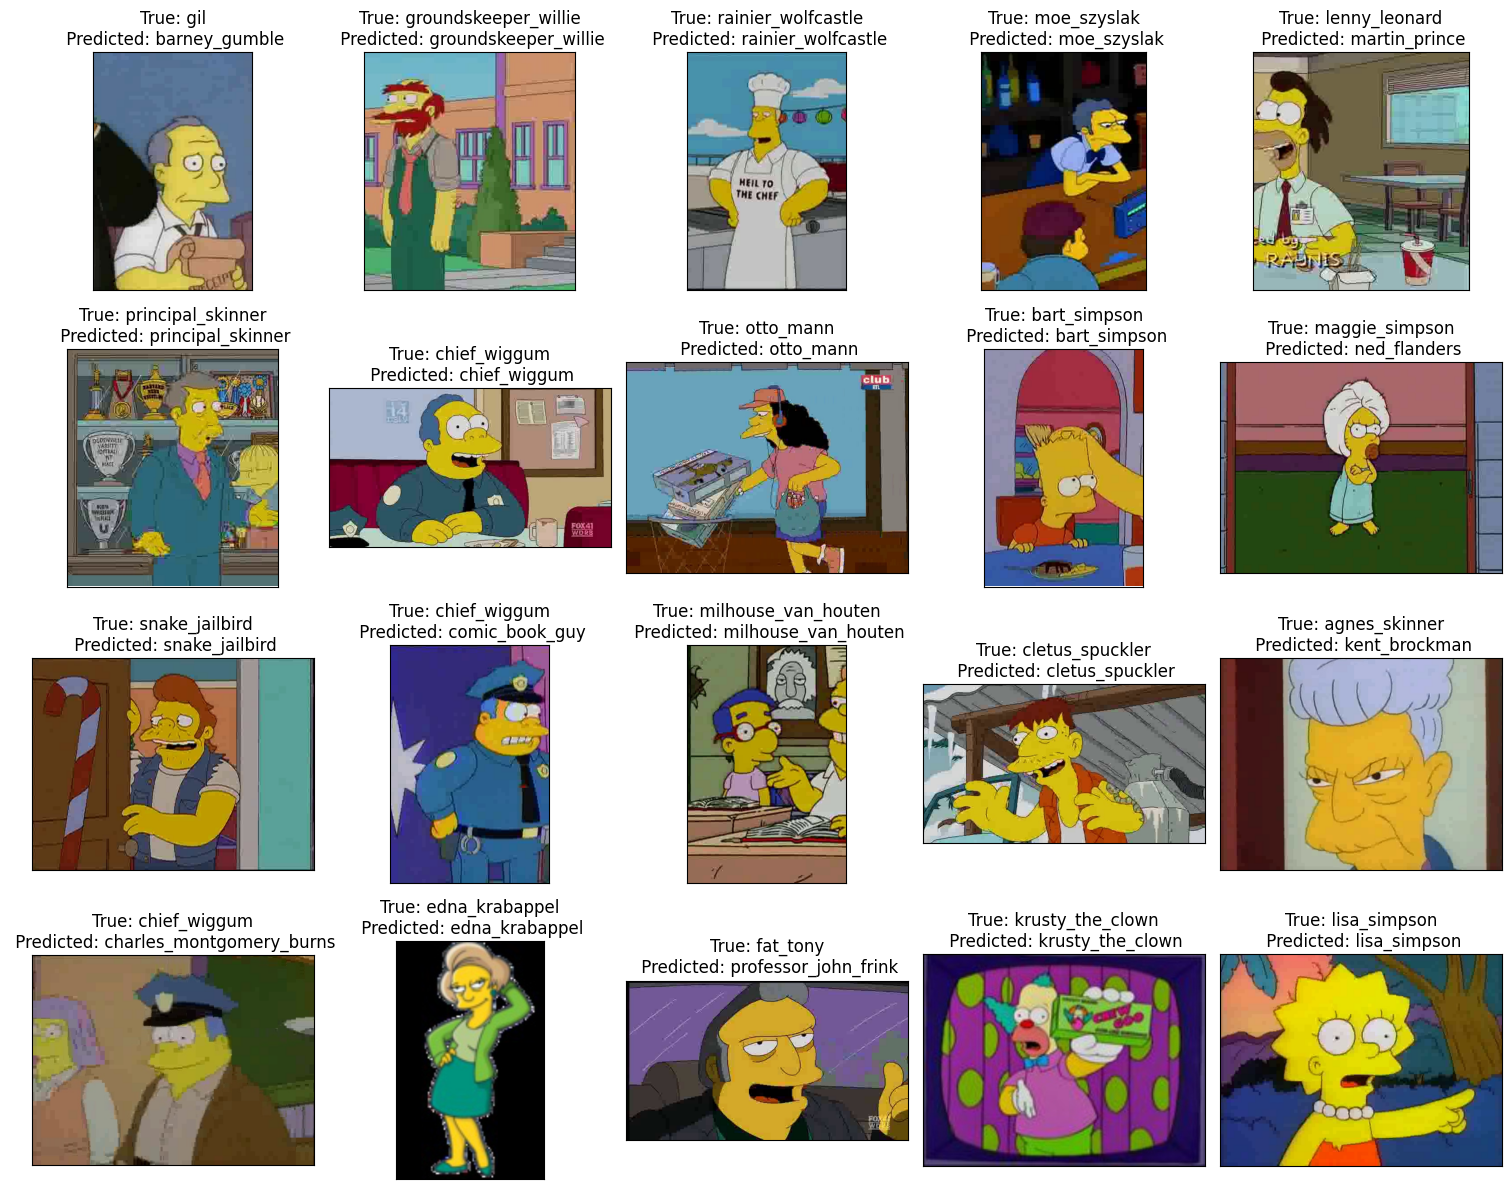

In [19]:
predict_15_imgs(best_from_custome_customized_model)

## Evaluation of **ResNet50 model** on test set

In [19]:
y_pred_RN50 = best_from_custome_RN50_model.predict(test_set)
y_pred_RN50 = np.argmax(y_pred_RN50, axis=1)

22/22 [==============================] - 21s 308ms/step


### Total number of mis-classifications

In [21]:
unequal_indices_RN50 = find_unequal_indexes(y_test_true, y_pred_RN50)

print(
    f"Total number of mis-classification by ResNet50: {len(unequal_indices_RN50)}, which is {round(len(unequal_indices_RN50)/len(y_test_true)*100, 1)}%"
)

Total number of mis-classification by ResNet50: 254, which is 11.9%


### Classification Report

The accuracy provided by the customized model is 88%, which is also good as previous model (customized model). However, look into the each indicators (precision, recall and f1-score), we can find that there is a gap between this model and previous model. The precision lower than 0.8, approximately accounts for one third. Among these, there are even more with precision below 0.6, some even around 0.4

In [140]:
class_report_RN50 = classification_report(
    y_test_true, y_pred_RN50, zero_division=1, target_names=labels
)
print(class_report_RN50)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.96      0.93      0.95        92
           agnes_skinner       0.50      0.60      0.55         5
  apu_nahasapeemapetilon       0.94      0.81      0.87        63
           barney_gumble       0.70      0.58      0.64        12
            bart_simpson       0.96      0.84      0.90       135
            carl_carlson       0.37      0.91      0.53        11
charles_montgomery_burns       0.95      0.86      0.90       120
            chief_wiggum       0.92      0.91      0.91       100
         cletus_spuckler       0.83      0.83      0.83         6
          comic_book_guy       0.77      0.83      0.80        48
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.91      0.83      0.87        47
                fat_tony       0.33      1.00      0.50         4
                     gil       0.67      0.50      0.57         4
    groun

### Support amount versus Precision

According to the below graphics, there are subtle relationships between precision and support amount (training data amount). When support amount which is the test data of specific classs over than 75, then its precision would around 80% to 100%. However, for the training data set, the results are quite scattered. We can see that for a precision of 90%, there are data amounts of 175, 375, 750, and 1000, indicating that in this model, imbalanced data doesn't have a significant impact compared to balanced data.

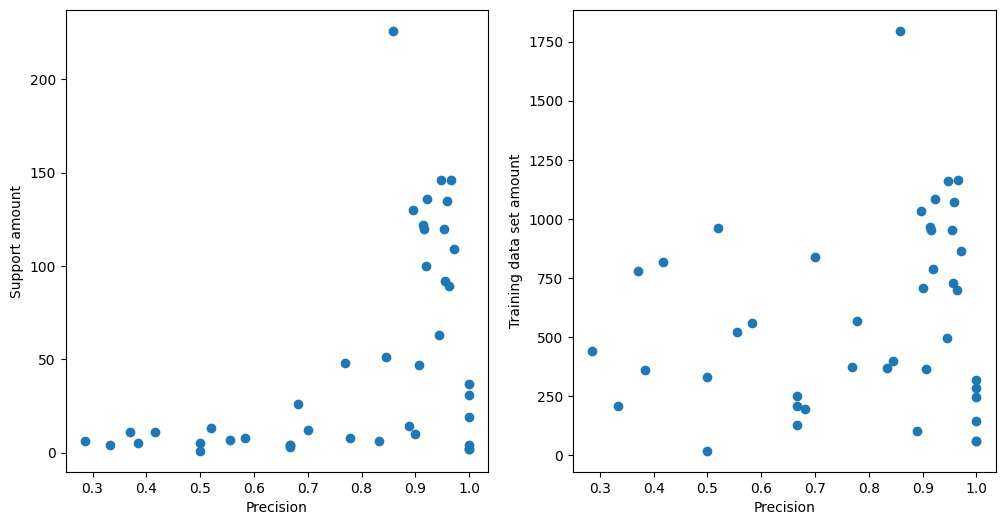

In [145]:
class_report_RN50 = classification_report(
    y_test_true, y_pred_RN50, zero_division=1, output_dict=True
)

plot_support_train_amt(class_report_RN50)

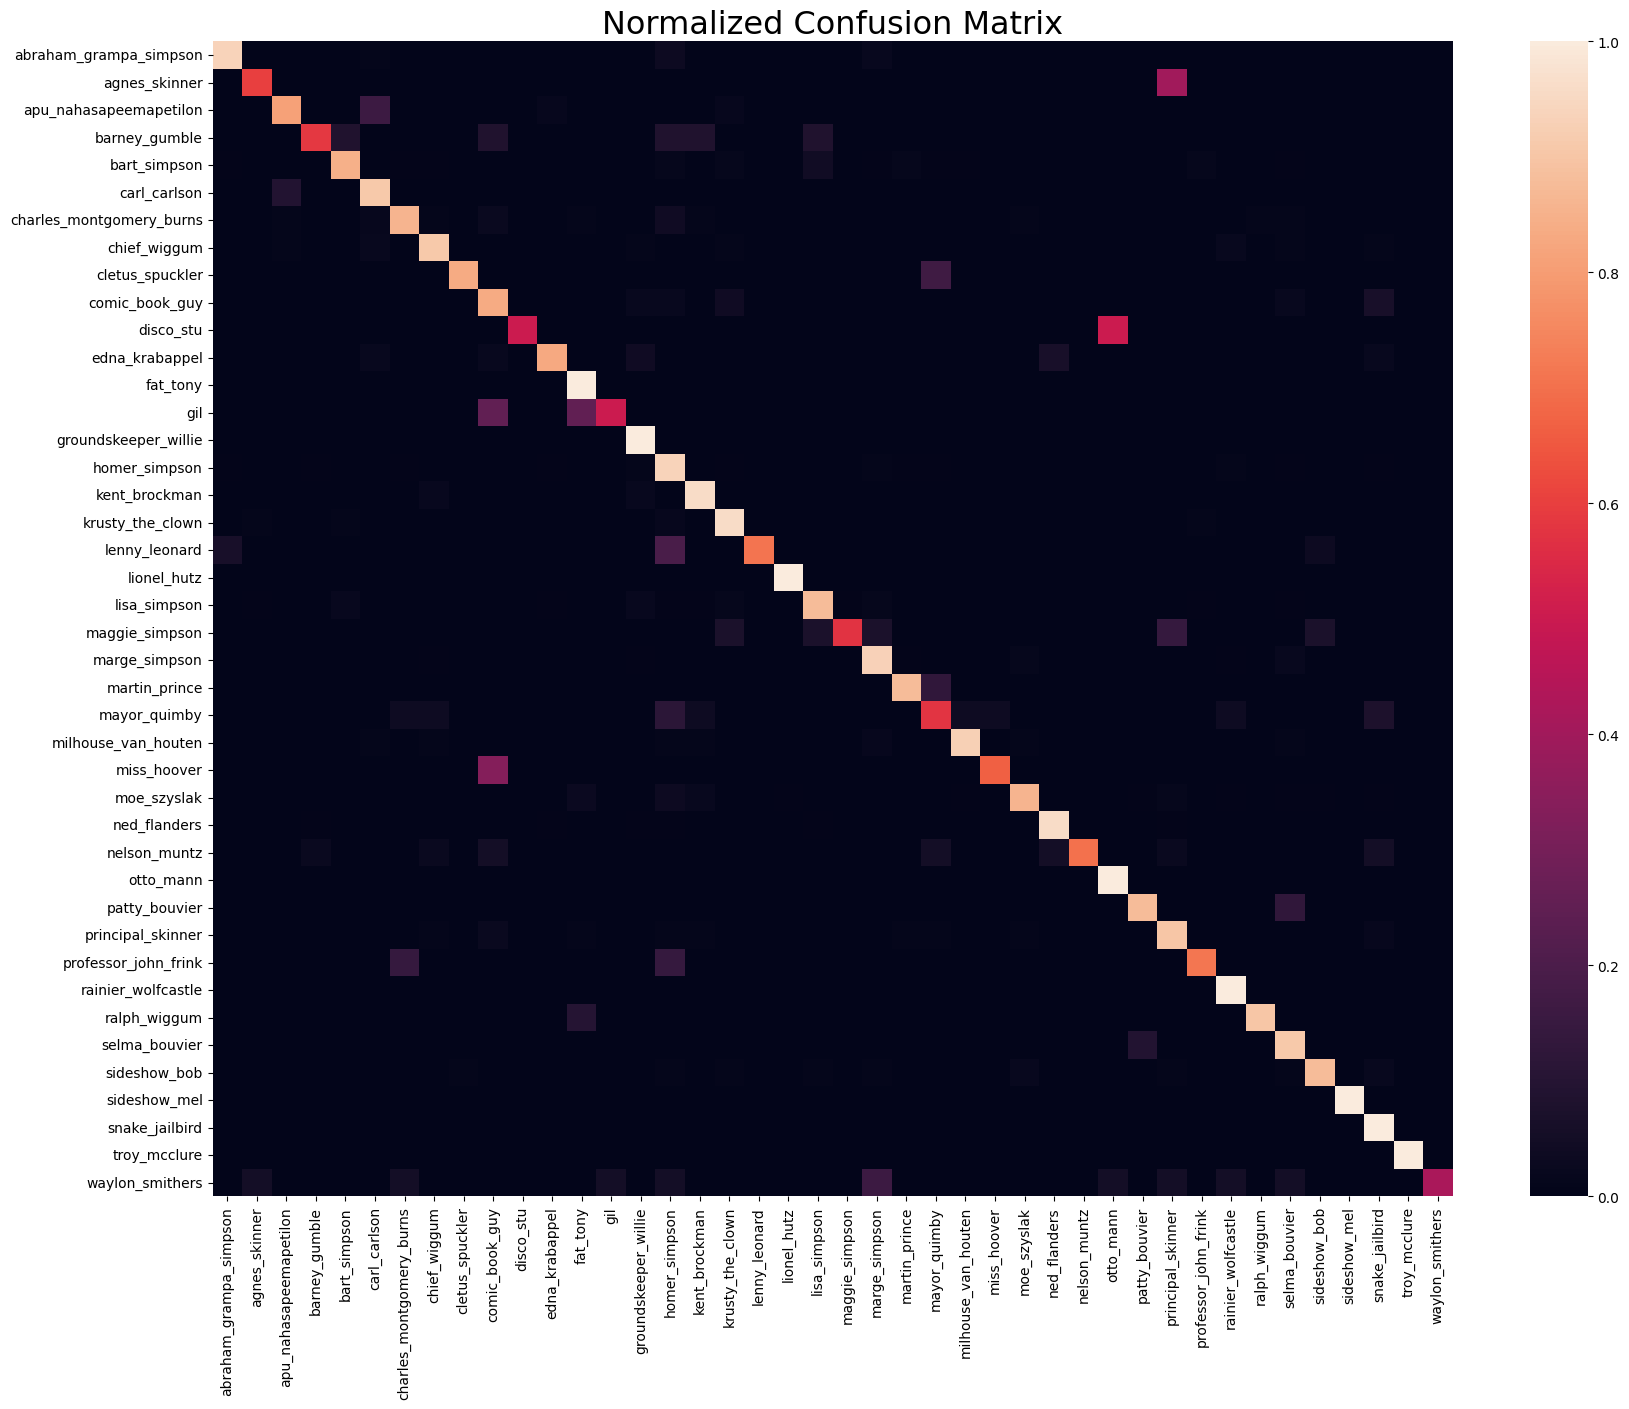

In [150]:
cf_matrix_RN50 = confusion_matrix(y_test_true, y_pred_RN50, normalize="true")
plot_confusion_matrix(cf_matrix_RN50)

### Plot the images that are most likely to be misclassified by the model

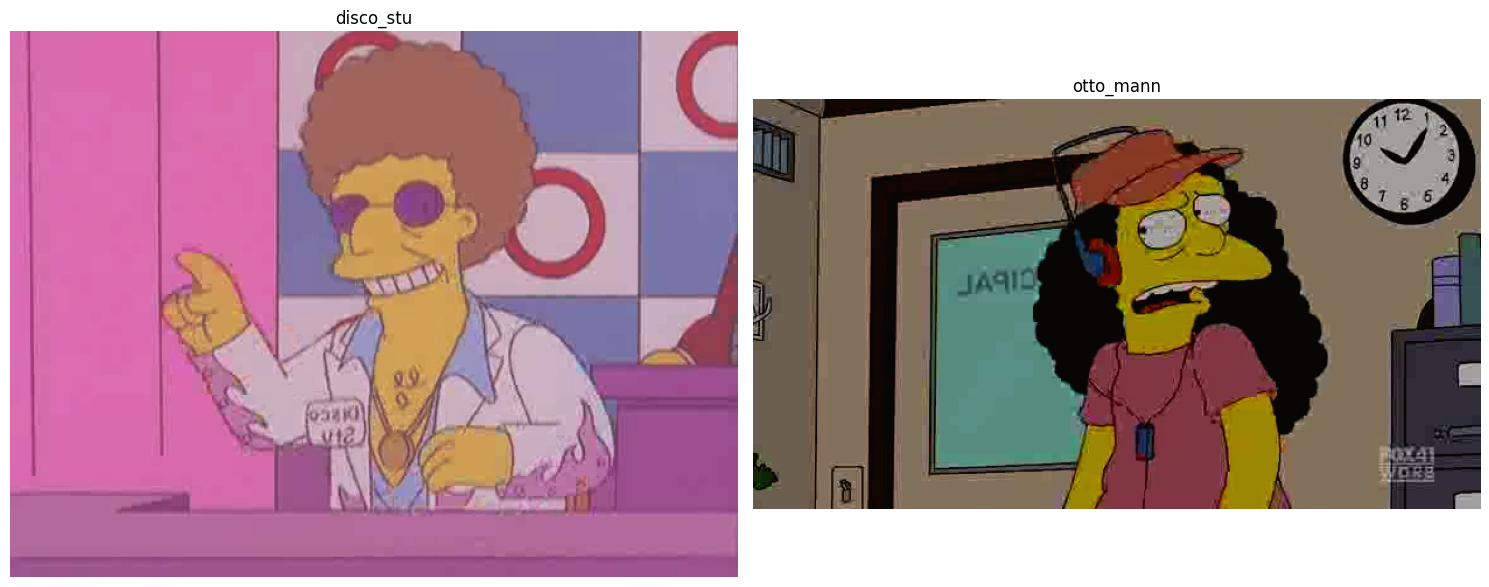

In [13]:
plot_specific_images('disco_stu', 'otto_mann')

### Evaluation of **Mobile Net V2** on test set

In [26]:
y_pred_MNV2 = best_from_custome_MNV2_model.predict(test_set)
y_pred_MNV2 = np.argmax(y_pred_MNV2, axis=1)

22/22 [==============================] - 5s 178ms/step


### Total number of mis-classifications

In [27]:
unequal_indices_MNV2 = find_unequal_indexes(y_test_true, y_pred_MNV2)

print(
    f"Total number of mis-classification by ResNet50: {len(unequal_indices_MNV2)}, which is {round(len(unequal_indices_MNV2)/len(y_test_true)*100, 1)}%"
)

Total number of mis-classification by ResNet50: 722, which is 33.8%


This is the worst-performing model, only 66% accuracy. This is also the reason I train the three models, because I want to find the better pre-trained model could compare to my customized model

In [160]:
class_report_MNV2 = classification_report(
    y_test_true, y_pred_MNV2, zero_division=1, target_names=labels
)
print(class_report_MNV2)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.70      0.70      0.70        92
           agnes_skinner       0.33      0.40      0.36         5
  apu_nahasapeemapetilon       0.86      0.78      0.82        63
           barney_gumble       0.33      0.50      0.40        12
            bart_simpson       0.68      0.81      0.74       135
            carl_carlson       0.42      0.91      0.57        11
charles_montgomery_burns       0.78      0.67      0.72       120
            chief_wiggum       0.85      0.72      0.78       100
         cletus_spuckler       0.09      0.50      0.15         6
          comic_book_guy       0.78      0.81      0.80        48
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.96      0.53      0.68        47
                fat_tony       0.50      0.50      0.50         4
                     gil       0.20      0.25      0.22         4
    groun

### Support amount versus Precision

Same situation with previous model (ResNet50), the support amount more than 50 have relatively high precision from 70% to 90%, then for the training data set, the results are quite scattered. Indicating that imbalanced data doesn't have a significant impact compared to balanced data.

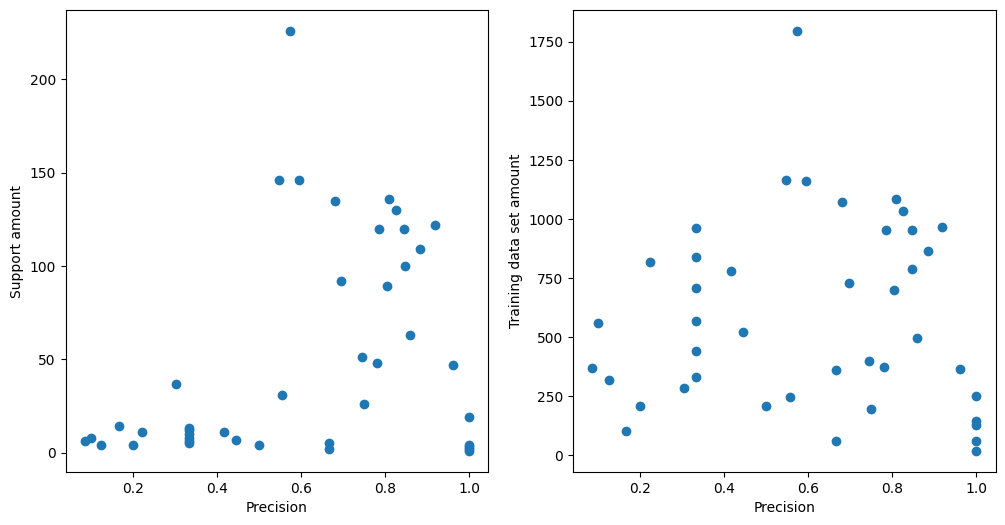

In [161]:
class_report_MNV2 = classification_report(
    y_test_true, y_pred_MNV2, zero_division=1, output_dict=True
)

plot_support_train_amt(class_report_MNV2)

This is the funnest part that this model predicted all cases should be "Lionel Hutz" to "Principal Skinner", it means the model has 100% misclassication on "Lionel Hutz".

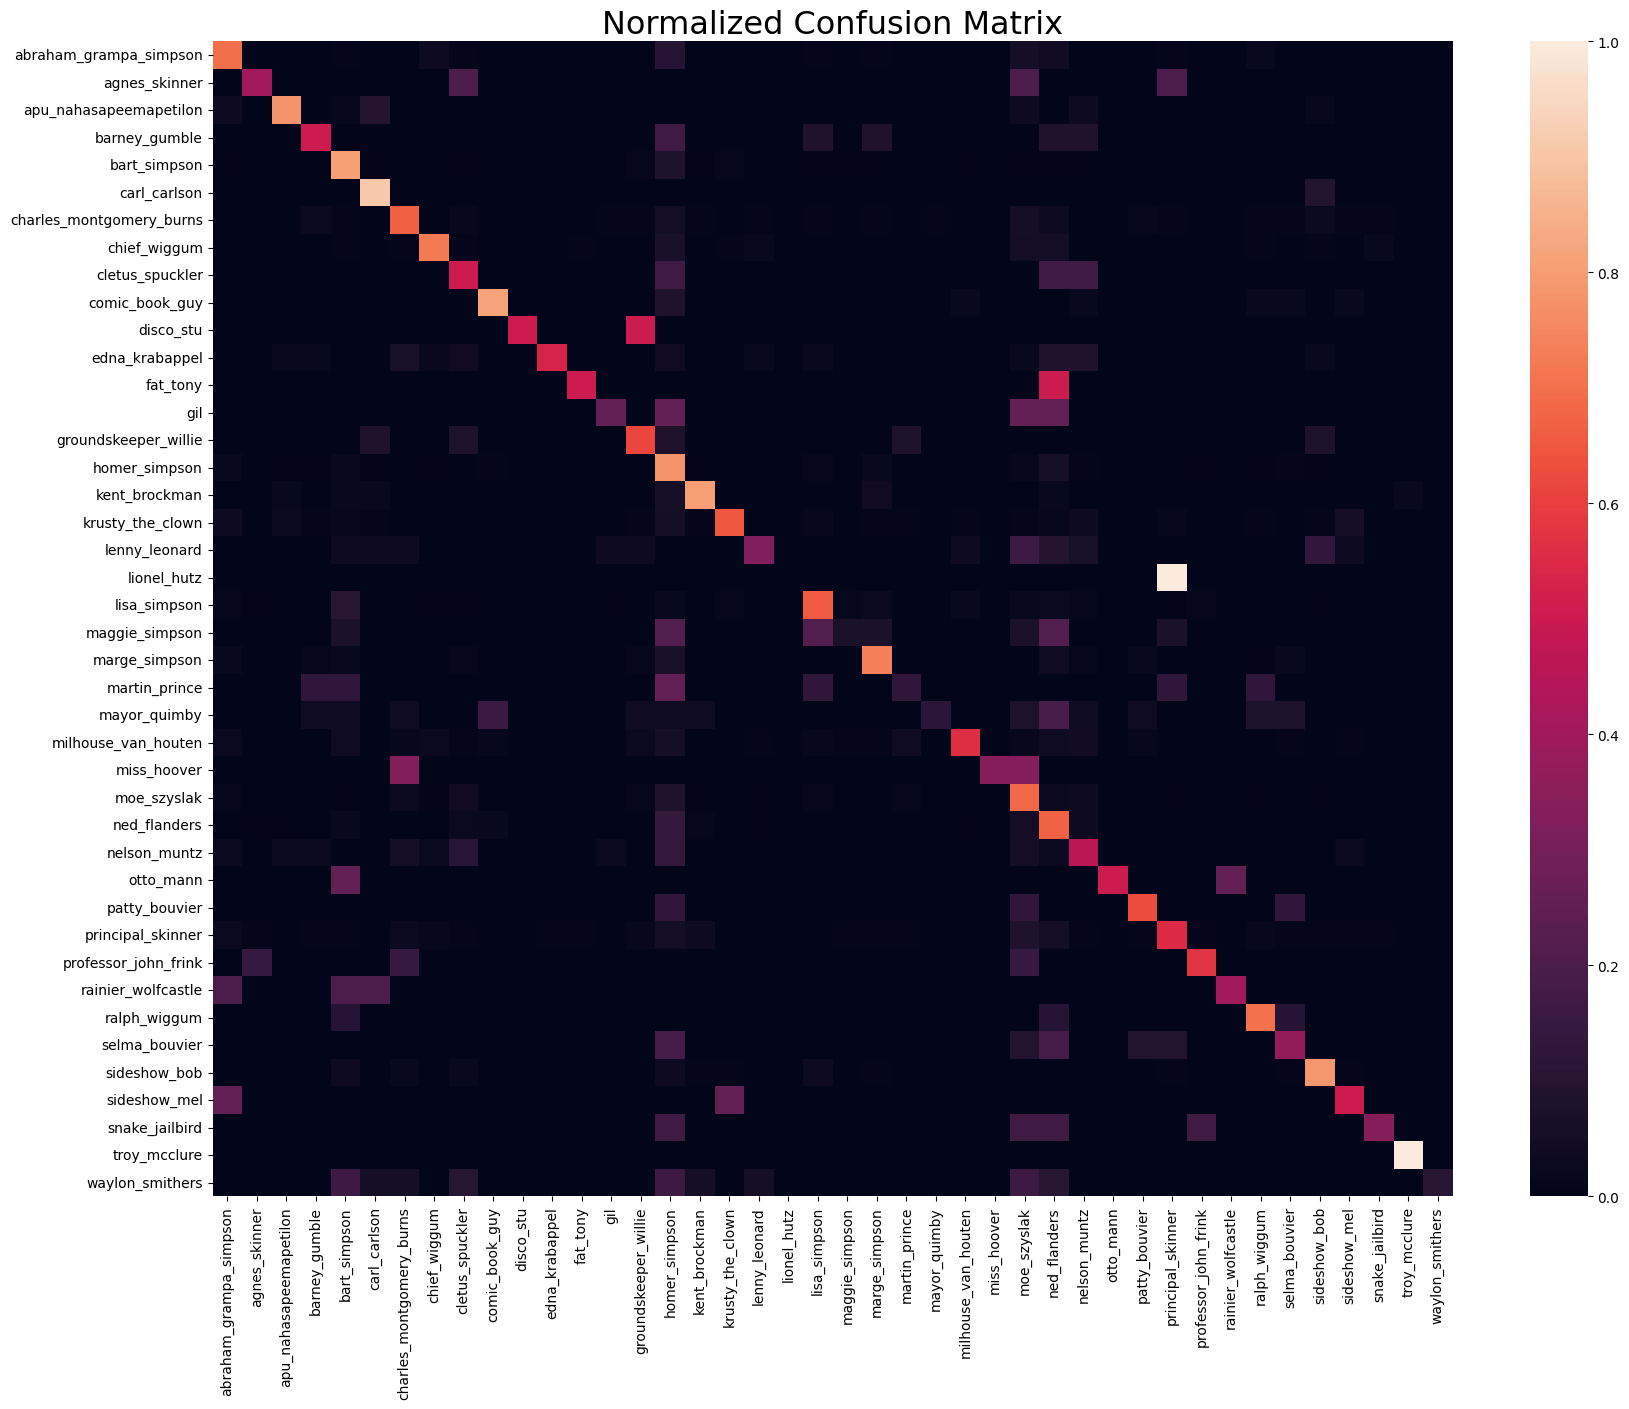

In [162]:
cf_matrix_MNV2 = confusion_matrix(y_test_true, y_pred_MNV2, normalize="true")
plot_confusion_matrix(cf_matrix_MNV2)

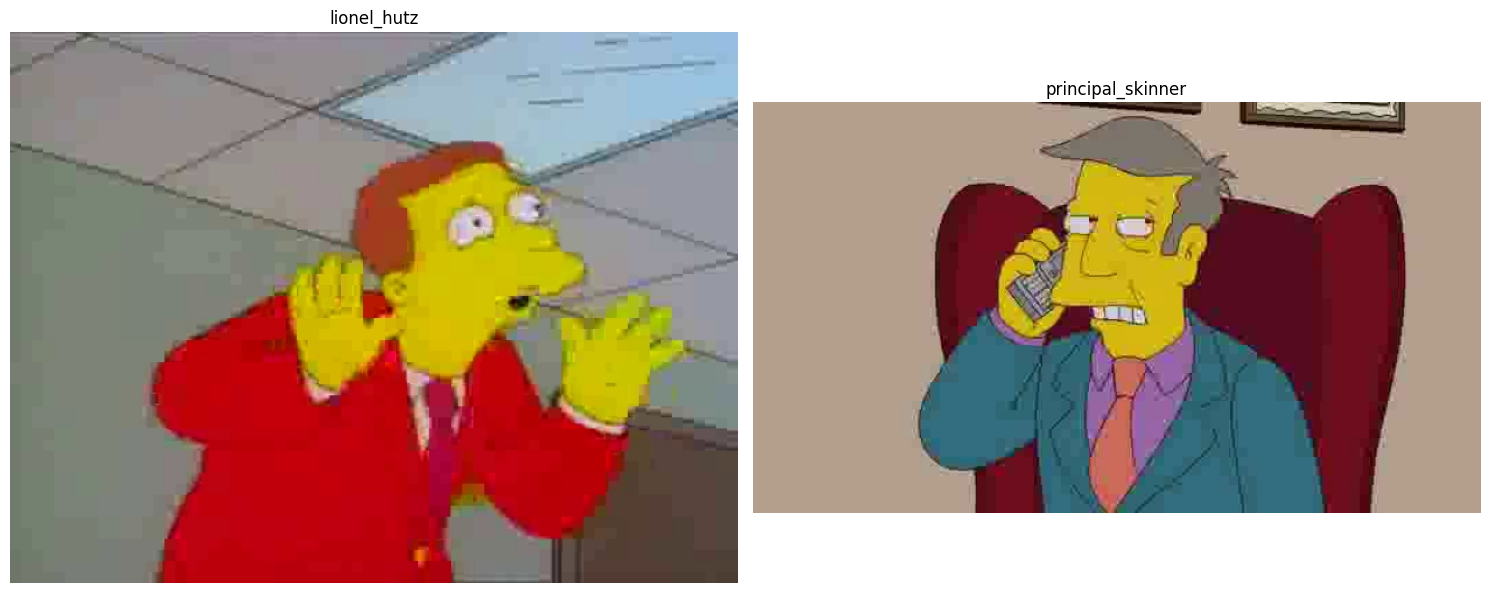

In [34]:
plot_specific_images('lionel_hutz', 'principal_skinner')

### Model Comparison

These numbers (Training Parameters, training time, losses, accuracies) are copy from the previous execution results.

In [188]:
import pandas as pd
comparision = {
    "Training Parameters": ['105,705,034', '339,114', '25,728,938'],
    "Model training time": ['91m 53s', '40m 34s', '34m 14s'],
    "Lowest loss": ['0.2658', '1.2937', '0.3887'],
    "with accuracy": ['93%', '63%', '89%'],
    "Highest accuracy": ['93%', '64%', '89%'],
    "with loss": ['0.2981', '1.3655', '0.3887'],
}
com_df = pd.DataFrame(comparision)
com_df

Training Parameters Model training time Lowest loss with accuracy  \
0         105,705,034             91m 53s      0.2658           93%   
1             339,114             40m 34s      1.2937           63%   
2          25,728,938             34m 14s      0.3887           89%   

  Highest accuracy with loss  
0              93%    0.2981  
1              64%    1.3655  
2              89%    0.3887

In [180]:
import matplotlib.pyplot as plt
import numpy as np

comparison = {
    "Training Parameters": ['105,705,034', '339,114', '25,728,938'],
    "Model training time": ['91', '40', '34'],
    "Highest validation accuracy": ['93%', '64%', '89%'],
    "with loss": ['0.2981', '1.3655', '0.3887'],
}

parameters = [int(param.replace(',', '')) for param in comparison["Training Parameters"]]
training_time = [int(time.split(' ')[0]) for time in comparison["Model training time"]]
lowest_loss = [float(loss) for loss in comparison["Lowest loss"]]
accuracy = [int(acc.replace('%', '')) for acc in comparison["with accuracy"]]


According to the graphics, we can see that these three models are quite different from each other based on their attributes. They have varying execution times, parameters, and performance

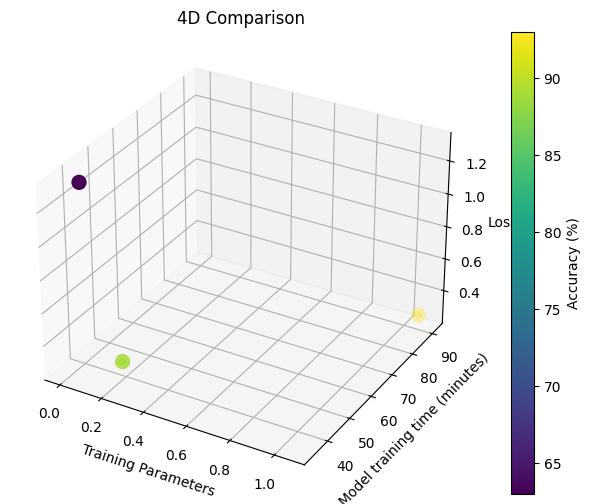

In [182]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(parameters, training_time, lowest_loss, c=accuracy, cmap='viridis', s=100)

ax.set_xlabel('Training Parameters')
ax.set_ylabel('Model training time (minutes)')
ax.set_zlabel('Loss')

cbar = plt.colorbar(ax.scatter(parameters, training_time, lowest_loss, c=accuracy, cmap='viridis'))
cbar.set_label('Accuracy (%)')

plt.title('4D Comparison')
plt.show()

I trained the model with GPU, however they took me several hours to train (I didn't just train each one once, maybe 3-4 times for each model), so based on the graphics I would definitely choose the shortest training time but with relatively better performance, which is the pre-trained model ResNet 50.

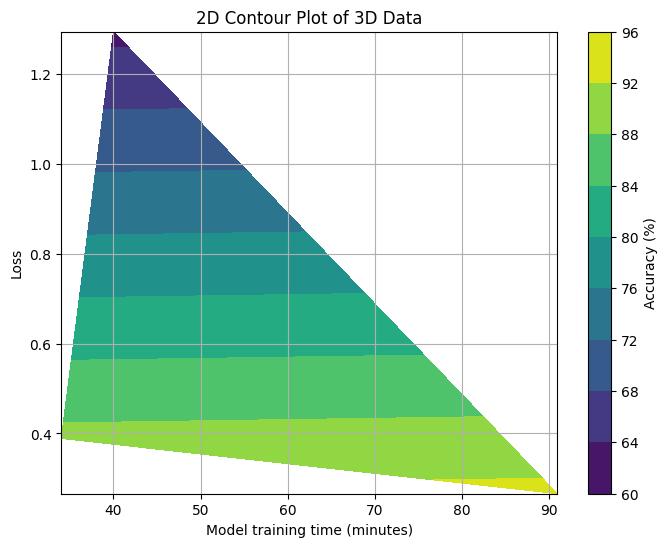

In [185]:
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(training_time, lowest_loss, accuracy, cmap='viridis')

plt.colorbar(contour, label='Accuracy (%)')

plt.xlabel('Model training time (minutes)')
plt.ylabel('Loss')

plt.title('2D Contour Plot of 3D Data')
plt.grid(True)
plt.show()